In [40]:
# Import general libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [37]:
# Run to turn ON interactive visualization
%matplotlib tk

In [41]:
# Run to turn OFF interactive visualization
%matplotlib inline

In [34]:
# Load the image data: loaded as a 2D numpy array
# dtype='>f4': 32 bit little-endian single-precision float
from astropy.io import fits
from auto_stretch import apply_stretch

# Load the image data
img_path = 'dataset/hst_skycell-p0048x16y13_acs_wfc_f658n_all_drc.fits'
raw_img = fits.getdata(img_path)

# Stretch the image for better visualization
stretched_img = apply_stretch(raw_img)


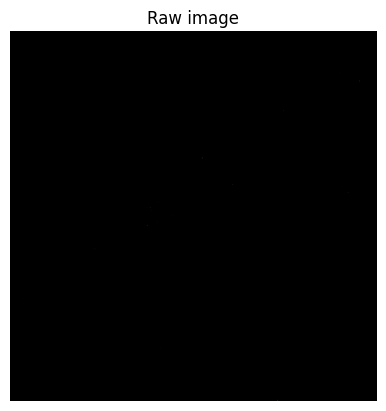

In [43]:
# Plot raw image
plt.imshow(raw_img, cmap='gray')
plt.title('Raw image')
plt.axis('off')
plt.show()

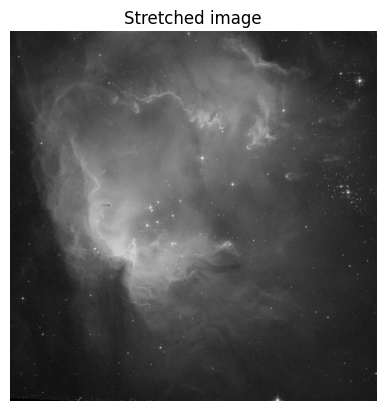

In [42]:
# Plot stretched image
plt.imshow(stretched_img, cmap='gray')
plt.title('Stretched image')
plt.axis('off')
plt.show()

In [6]:
# # COMPUTE A CONVOLUTION USING A GAUSSIAN KERNEL
# from math import ceil

# # Define Gaussian Kernel
# # FWHM: full width at half maximum, a measure to estimate the size of stars
# # compute the kernel for small/medium size stars, as bigger ones are fewer and can be treated separately
# FHWM = 7 # pixels
# sigma = ceil(FHWM / 2.355) # std deviation
# kernel_size = (6*sigma) + 1 # rule for kernel size

# print(f'Sigma: {sigma}')
# print(f'Kernel size: {kernel_size}x{kernel_size}')

# gauss_img = cv2.GaussianBlur(stretched_img, (kernel_size, kernel_size), sigma)

In [7]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# # Plot image BEFORE convolution against Gaussian kernel
# axes[0].imshow(stretched_img, cmap='gray')
# axes[0].set_title('BEFORE Gaussian Convolution')
# axes[0].axis('off')

# # Plot image AFTER convolution against Gaussian kernel
# axes[1].imshow(gauss_img, cmap='gray')
# axes[1].set_title('AFTER Gaussian Convolution')
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()

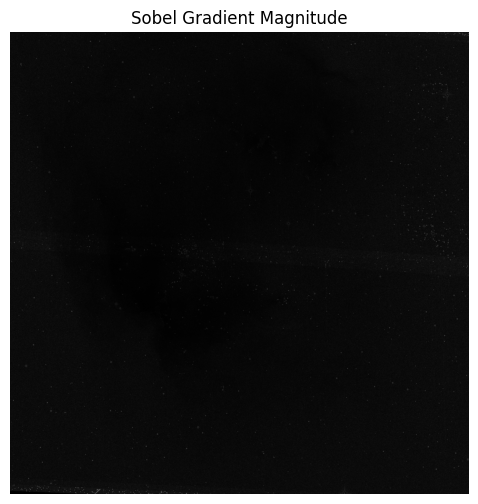

In [45]:
# Sobel gradient
sobel_x = cv2.Sobel(stretched_img, cv2.CV_32F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(stretched_img, cv2.CV_32F, 0, 1, ksize=3)
grad_mag = cv2.magnitude(sobel_x, sobel_y)

grad_mag

# Display the gradient magnitude
plt.figure(figsize=(12,6))
plt.imshow(grad_mag, cmap='gray')
plt.title('Sobel Gradient Magnitude')
plt.axis('off')
plt.show()

In [46]:
# Apply thresholding to the gradient magnitude
# Simple binary thresholding
T = 0.45 # threshold
print(T)
max_intensity = 1
_, binary_mask = cv2.threshold(grad_mag, T, max_intensity, cv2.THRESH_BINARY)
binary_mask

0.45


array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(4960, 4920), dtype=float32)

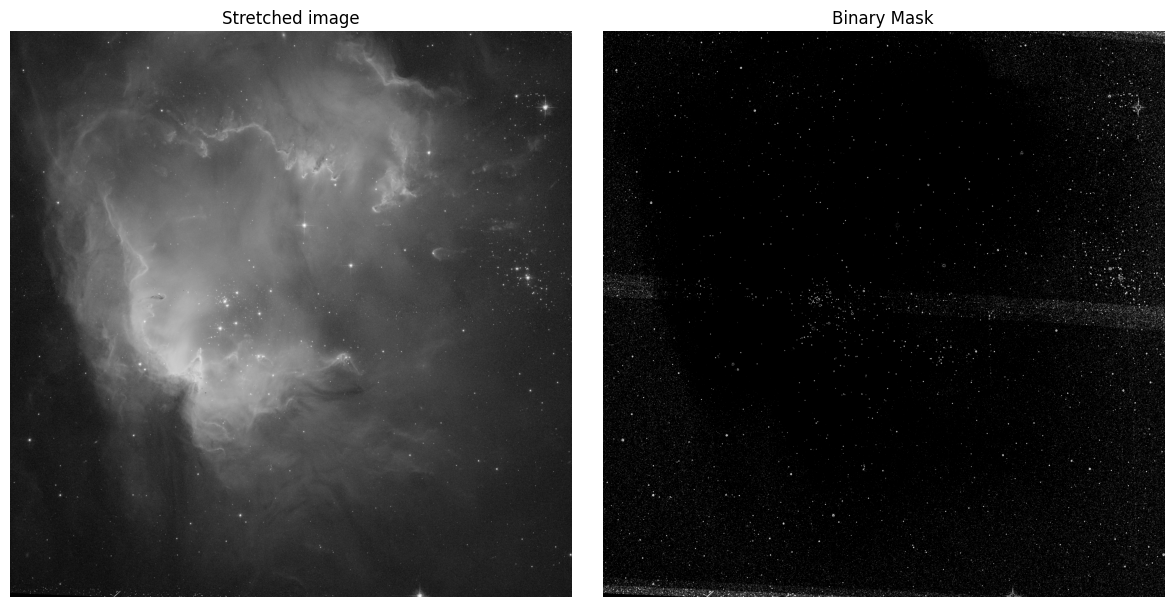

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot stretched image
axes[0].imshow(stretched_img, cmap='gray')
axes[0].set_title('Stretched image')
axes[0].axis('off')

# Plot binary mask
axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title('Binary Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [48]:
# Using morphological closing to close small gaps in edges before filling
def morph_close_and_fill(mask):
    # Convert binary mask to uint8 (0 - 255)
    mask_uint8 = (mask * 255).astype(np.uint8)
    # Create a kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    
    # Close small gaps in the edges
    closed_edges = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)
    
    # Find contours and fill
    contours, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    final_mask_uint8 = np.zeros_like(mask_uint8)
    cv2.drawContours(final_mask_uint8, contours, -1, 255, -1)
    
    # Back to float32 0.0/1.0
    final_mask = (final_mask_uint8.astype(np.float32) / 255.0)

    return final_mask, final_mask_uint8

final_mask, final_mask_uint8 = morph_close_and_fill(binary_mask)
final_mask.max(), final_mask_uint8.max()

(np.float32(1.0), np.uint8(255))

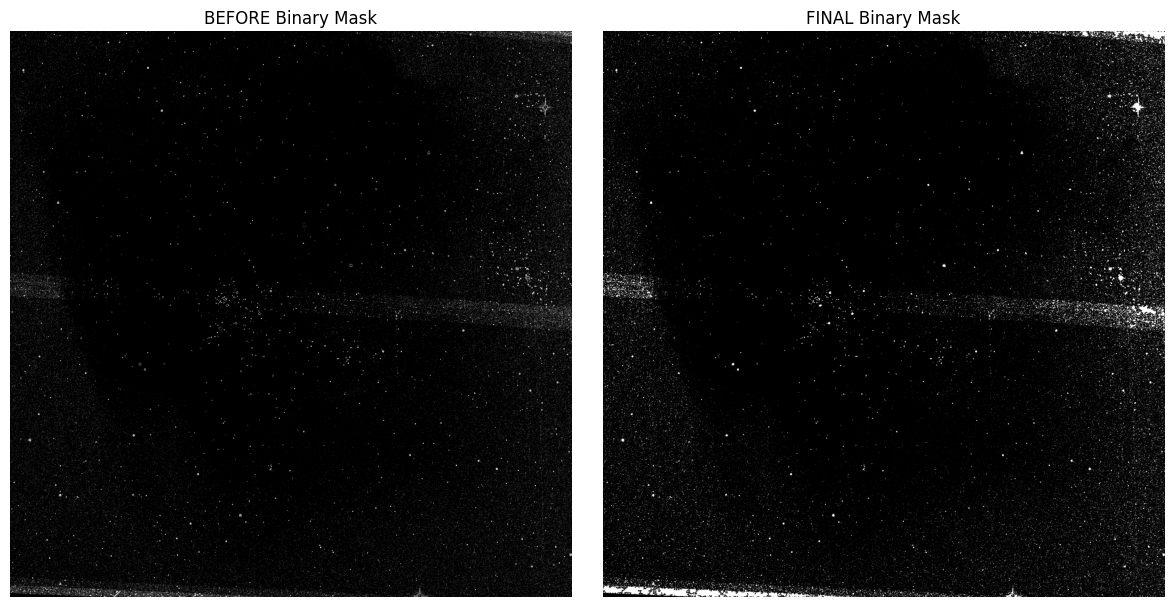

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot BEFORE binary mask
axes[0].imshow(binary_mask, cmap='gray')
axes[0].set_title('BEFORE Binary Mask')
axes[0].axis('off')

# Plot FINAL binary mask
axes[1].imshow(final_mask, cmap='gray')
axes[1].set_title('FINAL Binary Mask')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [13]:
# # TEST ON INPAINTING
# final_image_r5 = cv2.inpaint(
#     src=stretched_img, 
#     inpaintMask=final_mask_uint8, 
#     inpaintRadius=5, 
#     flags=cv2.INPAINT_NS
# )

# final_image_r7 = cv2.inpaint(
#     src=stretched_img, 
#     inpaintMask=final_mask_uint8, 
#     inpaintRadius=7, 
#     flags=cv2.INPAINT_NS
# )

# final_image_r10 = cv2.inpaint(
#     src=stretched_img, 
#     inpaintMask=final_mask_uint8, 
#     inpaintRadius=10, 
#     flags=cv2.INPAINT_NS
# )

# final_image_r15 = cv2.inpaint(
#     src=stretched_img, 
#     inpaintMask=final_mask_uint8, 
#     inpaintRadius=15, 
#     flags=cv2.INPAINT_NS
# )

In [14]:
# fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# axes[0,0].imshow(final_image_r5, cmap='gray')
# axes[0,0].set_title('Inpaint radius = 5')
# axes[0,0].axis('off')

# axes[0,1].imshow(final_image_r7, cmap='gray') # BEST RESULT
# axes[0,1].set_title('Inpaint radius = 7')
# axes[0,1].axis('off')

# axes[1,0].imshow(final_image_r10, cmap='gray')
# axes[1,0].set_title('Inpaint radius = 10')
# axes[1,0].axis('off')

# axes[1,1].imshow(final_image_r15, cmap='gray')
# axes[1,1].set_title('Inpaint radius = 15')
# axes[1,1].axis('off')

# plt.show()

# # grab the Tk window from the figure manager
# manager = plt.get_current_fig_manager()

# manager.window.attributes('-fullscreen', True)

In [15]:
# Perform inpainting for star removal
# gauss_img type: float32
# final_mask type: float32
# final_mask_uint8: uint8

# Apply Telea inpainting
final_image = cv2.inpaint(
    src=stretched_img, 
    inpaintMask=final_mask_uint8, 
    inpaintRadius=7, 
    flags=cv2.INPAINT_NS
)

final_image

array([[0.05857582, 0.14255674, 0.14876792, ..., 0.22708957, 0.16165842,
        0.14256173],
       [0.12918702, 0.15411541, 0.10855394, ..., 0.05651648, 0.13122998,
        0.15178487],
       [0.05277025, 0.05993678, 0.10263517, ..., 0.17303506, 0.14605653,
        0.20484062],
       ...,
       [0.        , 0.        , 0.        , ..., 0.12730469, 0.11771469,
        0.12475617],
       [0.        , 0.        , 0.        , ..., 0.10436684, 0.1179676 ,
        0.09140088],
       [0.        , 0.        , 0.        , ..., 0.13573948, 0.14491084,
        0.06989492]], shape=(4960, 4920), dtype=float32)

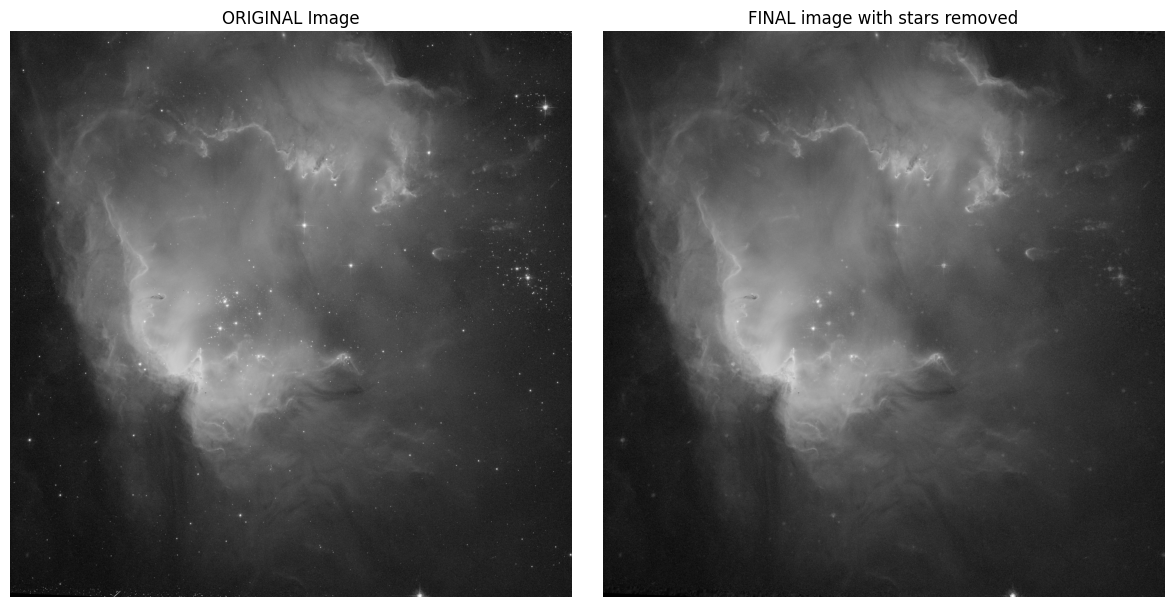

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot ORIGINAL image
axes[0].imshow(stretched_img, cmap='gray')
axes[0].set_title('ORIGINAL Image')
axes[0].axis('off')

# Plot FINAL image with stars removed
axes[1].imshow(final_image, cmap='gray')
axes[1].set_title('FINAL image with stars removed')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [51]:
# PERFORM A FINAL SMOOTHING ONLY IN STAR-PIXEL LOCATIONS
k = 15 # kernel size
full_smoothed_img = cv2.GaussianBlur(final_image, (k,k), 0)

# Create the final selectively smoothed image
final_smoothed_img = final_image.copy()
final_smoothed_img[final_mask_uint8 == 1] = full_smoothed_img[final_mask_uint8 == 1]


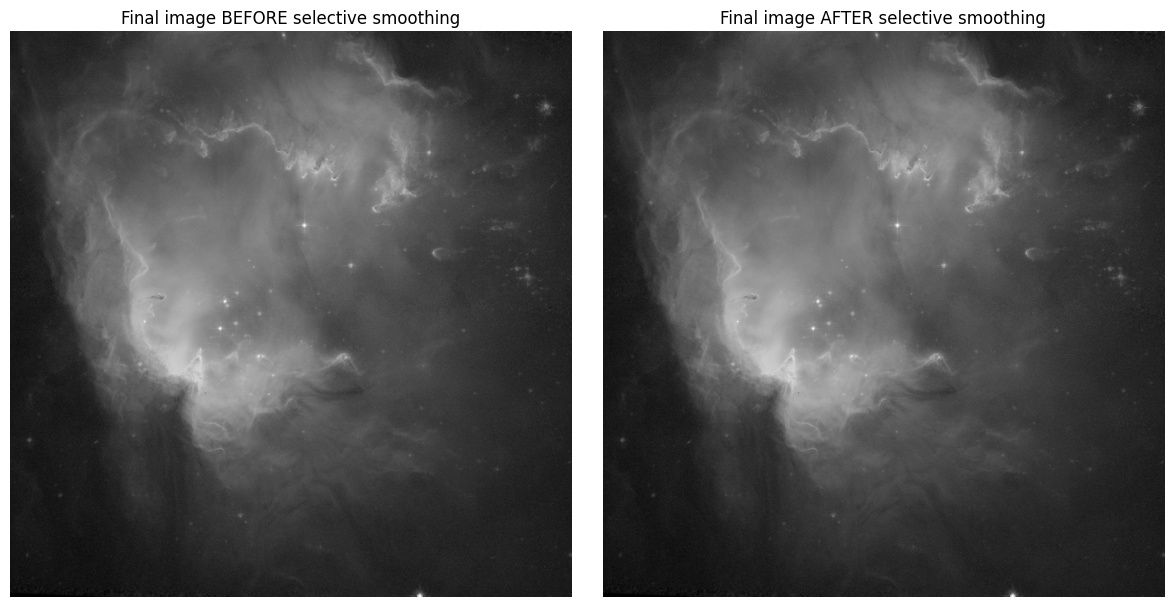

In [52]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot final image BEFORE selective smoothing
axes[0].imshow(final_image, cmap='gray')
axes[0].set_title('Final image BEFORE selective smoothing')
axes[0].axis('off')

# Plot final image AFTER selective smoothing
axes[1].imshow(final_smoothed_img, cmap='gray')
axes[1].set_title('Final image AFTER selective smoothing')
axes[1].axis('off')

plt.tight_layout()
plt.show()

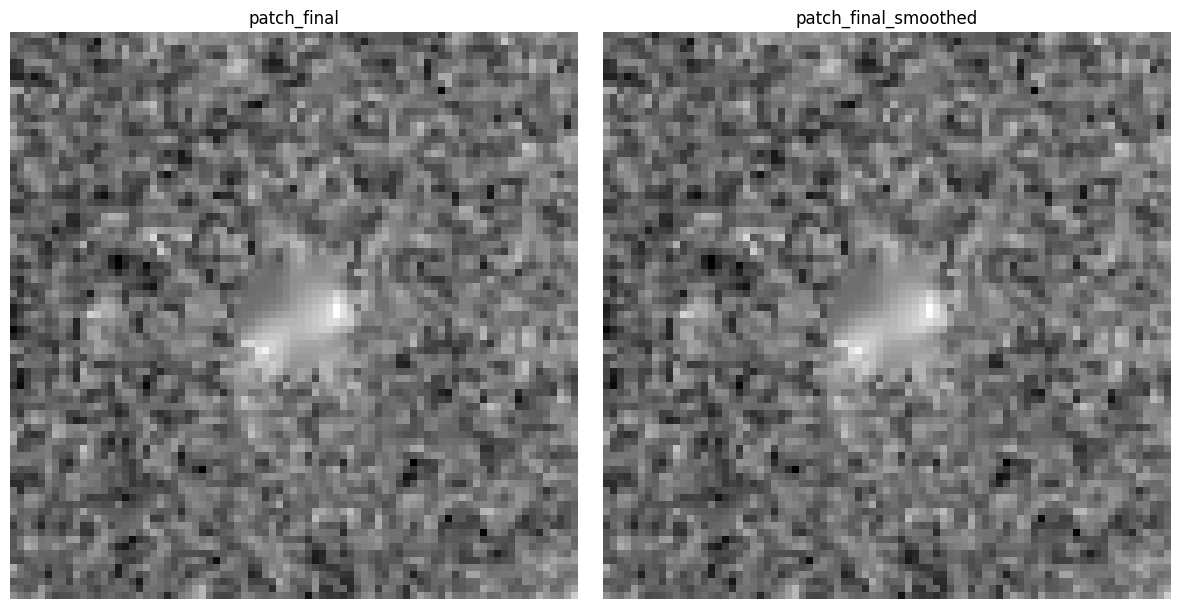

In [53]:
# Compare the results
half_size = 40
x, y = 1460, 4447

patch_final = final_image[y - half_size : y + half_size + 1,
              x - half_size : x + half_size + 1]
patch_final_smoothed = final_smoothed_img[y - half_size : y + half_size + 1,
              x - half_size : x + half_size + 1]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# 
axes[0].imshow(patch_final, cmap='gray')
axes[0].set_title('patch_final')
axes[0].axis('off')

# 
axes[1].imshow(patch_final_smoothed, cmap='gray')
axes[1].set_title('patch_final_smoothed')
axes[1].axis('off')

plt.tight_layout()
plt.show()

**Per Rick**

In [54]:
# # CREATE A .fits FILE FOR FINAL BINARY MASK
# # Create a primary HDU with the data
# hdu = fits.PrimaryHDU(data=final_mask)
# # Create a HDUList to contain the primary HDU
# hdul = fits.HDUList([hdu])
# # Write to file
# hdul.writeto('rick/MASK_hst_skycell-p0047x09y19_acs_wfc_f658n_all_drc.fits', overwrite=True)

# # CREATE A .fits FILE FOR FINAL IMAGE
# # Create a primary HDU with the data
# hdu = fits.PrimaryHDU(data=final_img)

# # Create a HDUList to contain the primary HDU
# hdul = fits.HDUList([hdu])

# # Write to file
# hdul.writeto('rick/OUTPUT_hst_skycell-p0047x09y19_acs_wfc_f658n_all_drc.fits', overwrite=True)